# Notebook 02: Preprocessing & Normalization

**Objective**: Normalize and preprocess single-cell data to make cells comparable.

## What you will learn:
- Why normalization is necessary
- Different normalization strategies
- Log transformation and its importance
- Data scaling for downstream analysis
- Identifying highly variable genes (HVGs)

## Key Concepts:

### Why Normalize?
Different cells have different **sequencing depths** (total counts):
- Some cells: 1,000 total counts
- Other cells: 10,000 total counts

**Problem**: A gene with 100 counts in the first cell (10% of total) is more important than the same gene with 100 counts in the second cell (1% of total).

**Solution**: Normalize to make cells comparable!

### Workflow:
1. Load filtered data from Notebook 01
2. Normalize counts (account for sequencing depth)
3. Log transform (stabilize variance)
4. Identify highly variable genes
5. Scale data (prepare for PCA)
6. Save preprocessed data

In [1]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Paths
data_dir = '../data/'
results_dir = '../results/'

print("Libraries imported successfully!")
print(f"Scanpy version: {sc.__version__}")

Libraries imported successfully!
Scanpy version: 1.11.4


## 1. Load Filtered Data

Load the filtered dataset from Notebook 01.

In [2]:
# Load filtered data
adata = sc.read_h5ad(f'{data_dir}pbmc3k_filtered.h5ad')

print("=" * 60)
print("LOADED DATA")
print("=" * 60)
print(adata)
print(f"\nDimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")

LOADED DATA
AnnData object with n_obs × n_vars = 2689 × 13671
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

📊 Dimensions: 2689 cells × 13671 genes


## 2. Save Raw Counts

**Important**: Before normalization, save the raw counts!

Why?
- Normalization transforms the data
- Some analyses (like differential expression) need raw counts
- We store raw counts in a separate "layer"

In [4]:
# Save raw counts in a layer
adata.layers['counts'] = adata.X.copy()

print("Raw counts saved in adata.layers['counts']")
print(f"Available layers: {list(adata.layers.keys())}")

Raw counts saved in adata.layers['counts']
Available layers: ['counts']


## 3. Normalization

### Method: Total-count normalization (CPM - Counts Per Million)

**Formula**: normalized_count = (count / total_counts_per_cell) × target_sum


**What it does**:
- Each cell is scaled to have the same total counts (target_sum)
- Default in Scanpy: **target_sum = 10,000** 
- Makes cells with different sequencing depths comparable
- Preserves relative gene expression within each cell

**Why 10,000 instead of 1 million (CPM)?**
- 10,000 is more intuitive for single-cell data
- Easier to interpret (e.g., "50 counts out of 10,000" = 0.5%)
- Mathematically equivalent (just a different scale)

**Example**:
- Cell A: 1,000 total counts, Gene X = 10 counts → normalized = 100
- Cell B: 10,000 total counts, Gene X = 10 counts → normalized = 10
- Now we can see Gene X is more important in Cell A!

In [7]:
# Reload filtered data (in case we ran normalization multiple times)
adata = sc.read_h5ad(f'{data_dir}pbmc3k_filtered.h5ad')
print("Data reloaded from filtered file")

Data reloaded from filtered file


normalizing counts per cell
    finished (0:00:00)


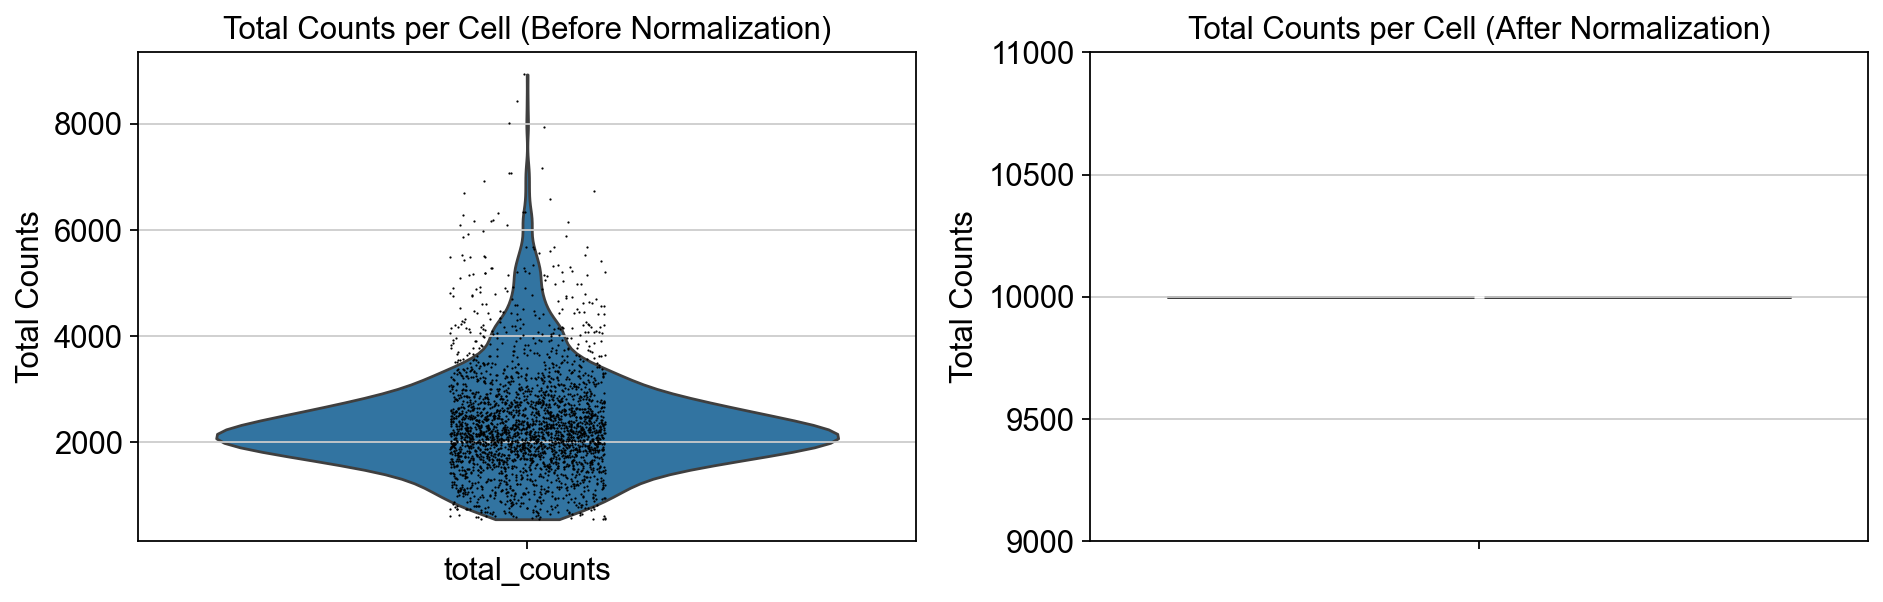

Normalization complete!
Target sum: 10,000 counts per cell
Mean: 10000.0, Min: 10000.0, Max: 10000.0


In [10]:
# Visualize total counts before normalization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before normalization
sc.pl.violin(adata, 'total_counts', ax=axes[0], show=False)
axes[0].set_title('Total Counts per Cell (Before Normalization)')
axes[0].set_ylabel('Total Counts')

# Normalize to 10,000 counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# After normalization - recalculate total counts
import scipy.sparse as sp
if sp.issparse(adata.X):
    total_after = np.array(adata.X.sum(axis=1)).flatten()
else:
    total_after = adata.X.sum(axis=1)

# Create a temporary dataframe for plotting
temp_df = pd.DataFrame({'total_counts_normalized': total_after})

# Plot using seaborn instead
sns.violinplot(data=temp_df, y='total_counts_normalized', ax=axes[1])
axes[1].set_title('Total Counts per Cell (After Normalization)')
axes[1].set_ylabel('Total Counts')
axes[1].set_ylim([9000, 11000])  # Focus on the 10k range

plt.tight_layout()
plt.savefig(f'{results_dir}02_normalization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Normalization complete!")
print(f"Target sum: 10,000 counts per cell")
print(f"Mean: {total_after.mean():.1f}, Min: {total_after.min():.1f}, Max: {total_after.max():.1f}")

## 4. Log Transformation

### Why log transform?

**Problem**: Gene expression is highly skewed
- Most genes: low expression (0-10 counts)
- Few genes: very high expression (1000+ counts)

**Solution**: Log transformation compresses the range

**Formula**: `log(count + 1)`
- The "+1" prevents log(0) = -infinity

**Benefits**:
- Stabilizes variance across expression levels
- Makes data more normally distributed
- Improves downstream analysis (PCA, clustering)

In [13]:
# Reload and re-normalize (in case we ran cells multiple times)
adata = sc.read_h5ad(f'{data_dir}pbmc3k_filtered.h5ad')
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
print("✅ Data reloaded and normalized (ready for log transformation)")

normalizing counts per cell
    finished (0:00:00)
✅ Data reloaded and normalized (ready for log transformation)


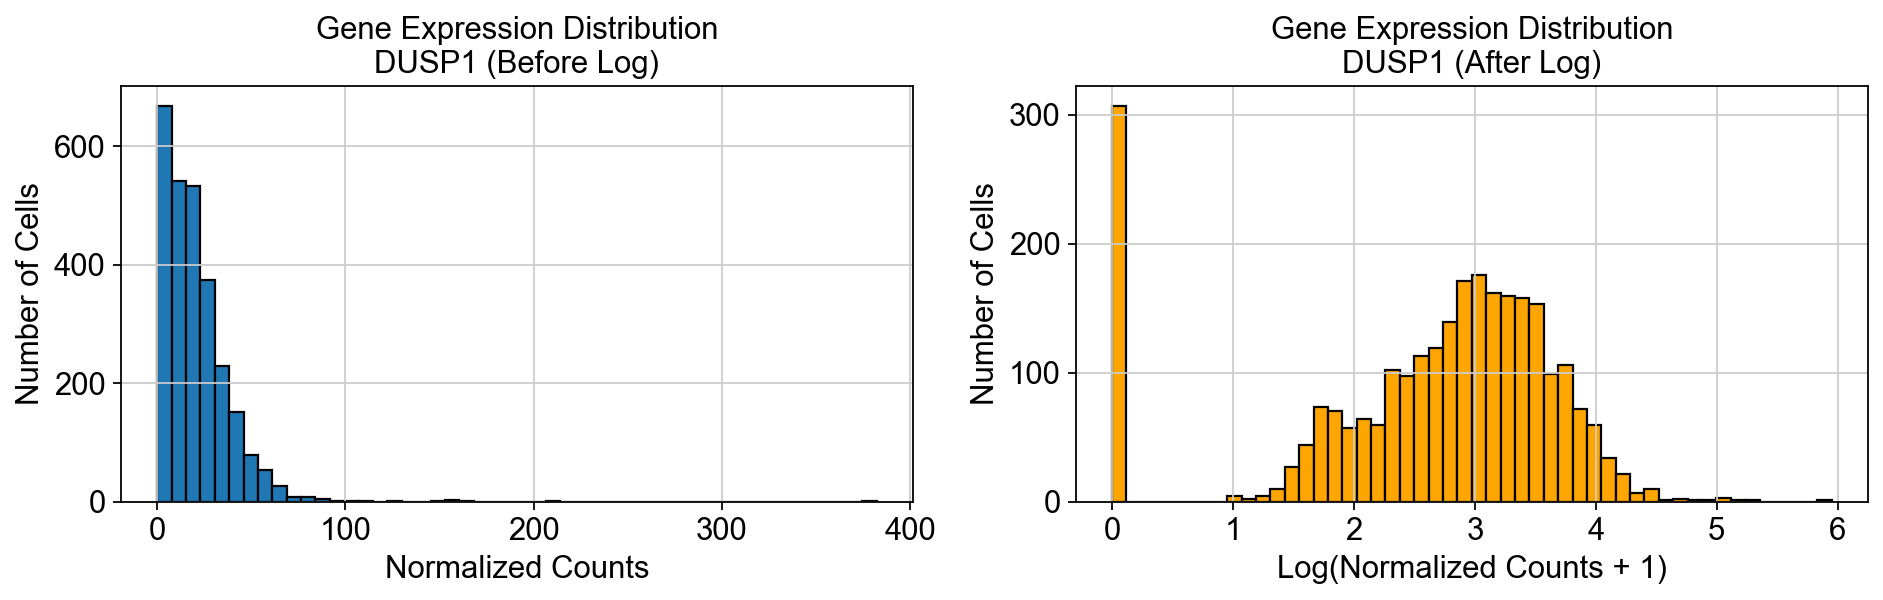

✅ Log transformation complete!
Gene used for visualization: DUSP1
Data is now log-normalized


In [14]:
# Visualize distribution before and after log transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Select a highly expressed gene for better visualization
# Calculate mean expression to find a good example gene
import scipy.sparse as sp
if sp.issparse(adata.X):
    mean_expression = np.array(adata.X.mean(axis=0)).flatten()
else:
    mean_expression = adata.X.mean(axis=0)

# Find a gene with moderate-to-high expression
gene_idx = np.argsort(mean_expression)[-100]  # 100th most expressed gene
gene_name = adata.var_names[gene_idx]

# Extract gene expression (before log)
if sp.issparse(adata.X):
    gene_expr_before = np.array(adata.X[:, gene_idx].toarray()).flatten()
else:
    gene_expr_before = adata.X[:, gene_idx]

# Before log transformation
axes[0].hist(gene_expr_before, bins=50, edgecolor='black')
axes[0].set_title(f'Gene Expression Distribution\n{gene_name} (Before Log)')
axes[0].set_xlabel('Normalized Counts')
axes[0].set_ylabel('Number of Cells')

# Log transform
sc.pp.log1p(adata)

# Extract gene expression (after log)
if sp.issparse(adata.X):
    gene_expr_after = np.array(adata.X[:, gene_idx].toarray()).flatten()
else:
    gene_expr_after = adata.X[:, gene_idx]

# After log transformation
axes[1].hist(gene_expr_after, bins=50, edgecolor='black', color='orange')
axes[1].set_title(f'Gene Expression Distribution\n{gene_name} (After Log)')
axes[1].set_xlabel('Log(Normalized Counts + 1)')
axes[1].set_ylabel('Number of Cells')

plt.tight_layout()
plt.savefig(f'{results_dir}02_log_transformation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Log transformation complete!")
print(f"Gene used for visualization: {gene_name}")
print("Data is now log-normalized")

## 5. Identify Highly Variable Genes (HVGs)

### Why select highly variable genes?

**Problem**: Not all genes are informative
- ~13,000 genes in our dataset
- Many genes: constant expression across cells (housekeeping genes)
- Some genes: high variability = biological signal!

**Solution**: Select genes with high biological variance

**Benefits**:
- Reduces noise
- Focuses on biologically relevant genes
- Speeds up computation
- Improves clustering and visualization

**Typical selection**: Top 2,000-4,000 most variable genes

In [16]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,  # Select top 2000 HVGs
    flavor='seurat',    # Method: Seurat (popular method)
    batch_key=None      # No batch correction for now
)

# Summary
print("=" * 60)
print("HIGHLY VARIABLE GENES SUMMARY")
print("=" * 60)
print(f"Total genes: {adata.n_vars}")
print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")
print(f"Percentage: {100 * adata.var['highly_variable'].sum() / adata.n_vars:.1f}%")

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
HIGHLY VARIABLE GENES SUMMARY
Total genes: 13671
Highly variable genes: 2000
Percentage: 14.6%


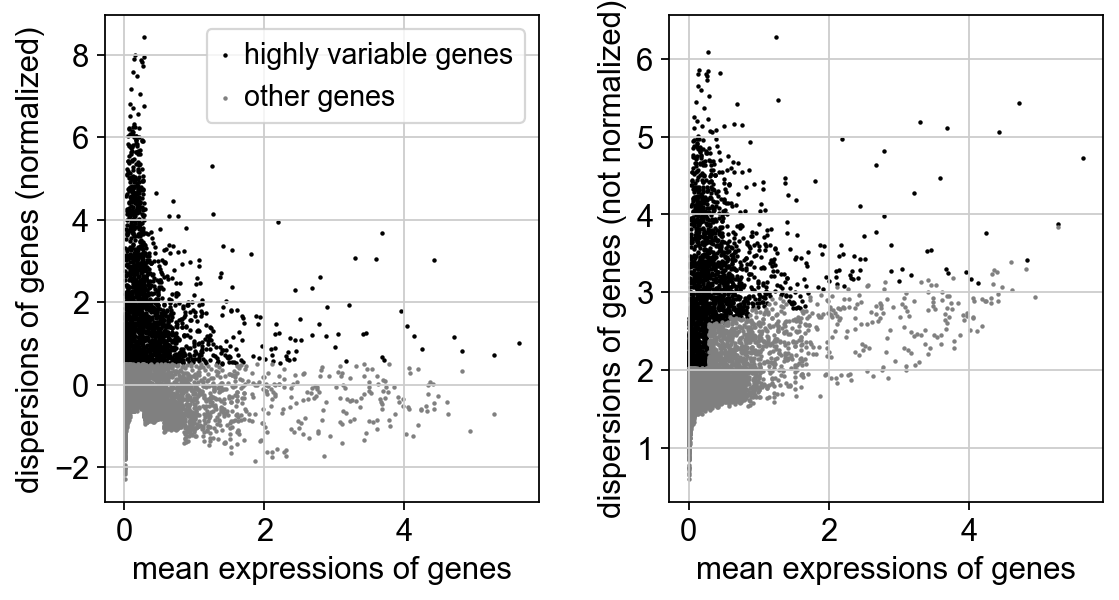

Highly variable genes identified!


In [18]:
# Visualize highly variable genes
sc.pl.highly_variable_genes(adata, show=False)
plt.savefig(f'{results_dir}02_highly_variable_genes.png', dpi=150, bbox_inches='tight')
plt.show()

print("Highly variable genes identified!")

## 6. Scale Data (Regress Out Unwanted Variation)

### Why scale?

**Goal**: Make genes comparable for PCA

**What scaling does**:
1. **Centers** each gene: mean = 0
2. **Scales** each gene: standard deviation = 1

**Optional**: Regress out technical effects
- Total counts per cell
- Mitochondrial percentage

**Note**: We'll do basic scaling without regression for now.

In [19]:
# Save the current state before scaling
adata.raw = adata

# Scale data (only on HVGs for efficiency)
sc.pp.scale(adata, max_value=10)

print("✅ Data scaled!")
print("Mean = 0, Std = 1 for each gene")
print(f"Clipped values to max = 10 (removes extreme outliers)")

/opt/anaconda3/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Data scaled!
Mean = 0, Std = 1 for each gene
Clipped values to max = 10 (removes extreme outliers)


## 7. Save Preprocessed Data

Save the preprocessed data for downstream analysis.

In [20]:
# Save preprocessed data
adata.write(f'{data_dir}pbmc3k_preprocessed.h5ad')

print("✅ Preprocessed data saved!")
print(f"File: {data_dir}pbmc3k_preprocessed.h5ad")
print(f"\n📊 Final dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")

✅ Preprocessed data saved!
File: ../data/pbmc3k_preprocessed.h5ad

📊 Final dimensions: 2689 cells × 13671 genes


## 📋 Summary

### What we accomplished:

1. **Loaded filtered data** (2,689 cells × 13,671 genes)
2. **Saved raw counts** in `adata.layers['counts']`
3. **Normalized counts** to 10,000 per cell (CPM normalization)
4. **Log transformed** data to stabilize variance
5. **Identified 2,000 highly variable genes** (HVGs)
6. **Scaled data** (mean=0, std=1) for PCA
7. **Saved preprocessed data** for downstream analysis

### Data transformations:

| Step | Purpose | Result |
|------|---------|--------|
| **Normalization** | Account for sequencing depth | Cells are comparable |
| **Log transform** | Stabilize variance | Better distribution |
| **HVG selection** | Focus on biological signal | 2,000 informative genes |
| **Scaling** | Prepare for PCA | Mean=0, Std=1 |

### Next steps: Notebook 03 - Dimensionality Reduction

In the next notebook, we will:
1. **PCA** - Reduce dimensions from 2,000 genes to ~50 components
2. **UMAP** - Visualize cells in 2D space
3. **t-SNE** - Alternative visualization method
4. **Interpret** principal components

---

**Great job! Your data is now ready for dimensionality reduction!**